# Boston airbnb project

In this project I will be analysing the Boston airbnb data using the CRISP-DM process. 
Therefore this notebook will be broken down into the following sections (in accordance to CRISP-DM)

* Business Understanding
* Data Understanding
* Data Preparation
* Modelling
* Evaluation
* Deployment



## Business Understanding

Airbnb provides a service which helps to match people who are looking to rent with people who are looking to lend. Airbnb uses a __fee for host__ model as their main source of income where a service fee is charged to a visitor and a renting fee is extracted from the host.

This notebook will try to focus on how to maximise the price of a given accomodation and also look into how to maximise value for potential visitors.

__Questions to be answered__

* __Which rooms are the most profitable to rent out?__
* __Which locations offer the best bang for buck in terms of renting?__
* __Which factors affect pricing the most?__ 

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Data understanding

The data used in the analysis was obtained from https://www.kaggle.com/airbnb/boston and contains data about Airbnb activity in Boston.

The data used in the analysis is from `listings.csv` and it provides the full descriptions of a listing along with its average review scores.

In [47]:
df = pd.read_csv('listings.csv')

## Data preparation

Prior to starting the data modelling phase it is important to clean the data. This means performing preprocessing to transform the data into a more useful form. This typically means dropping irrelevant features and imputing missing values.

The data was obtained from https://www.kaggle.com/airbnb/boston and contains data about Airbnb activity in Boston.

The data used in the analysis is from `listings.csv` and it provides the full descriptions of a listing along with its average review scores

In [48]:
df = pd.read_csv('listings.csv') #Load in the data

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

There seems to be a lot of objects and it'll be difficult to analyse all of them. Furthermore not all of the 'review scores' will be necessary for the data analysis. The relevant columns have been chosen but it is important to remember that the columns selected are subjective to personal opinion.

In [50]:
#Get the relevant columns
columns = ['host_id','neighbourhood_cleansed','review_scores_value','price','room_type',
           'reviews_per_month','availability_365','calculated_host_listings_count', 
           'neighbourhood_group_cleansed','longitude', 'latitude']
listings = df[columns]

The first thing to do is to find out how much of the data is missing

In [51]:
listings.isna().mean()

host_id                           0.000000
neighbourhood_cleansed            0.000000
review_scores_value               0.229010
price                             0.000000
room_type                         0.000000
reviews_per_month                 0.210879
availability_365                  0.000000
calculated_host_listings_count    0.000000
neighbourhood_group_cleansed      1.000000
longitude                         0.000000
latitude                          0.000000
dtype: float64

The neighbourhood_group_cleansed is useless since it is full of missing data. As a result it will be dropped.

In [52]:
listings = listings.drop(columns=['neighbourhood_group_cleansed'])

The reviews_per_month column also has some missing values. If the number of reviews is unknown number then there were probably no reviews to begin with. This will be rectified using the `fillna` function to replace unknown values with a value of 0.

In [53]:
listings.reviews_per_month.fillna(value=0,inplace=True)

The final missing value are for the review_scores_value. It is safe to assume that this will be likely be the mean value of the review_scores_value column

In [54]:
mean_rating = listings.review_scores_value.mean()
listings.review_scores_value.fillna(value=mean_rating,inplace=True)

The price should also be a float however it appears to be a string. Therefore it is important to identify what the string format is by using the head function

In [55]:
listings['price'].head()

0    $250.00
1     $65.00
2     $65.00
3     $75.00
4     $79.00
Name: price, dtype: object

It was later discovered that there are also commas present in the listings so these commas must also be removed along with the $ signs

In [56]:
def price_str2num(price):
    """
    This function converts pricing in the form a string $9.99 to a float 9.99
    or the string in the form $1,400,00 to the float 1400.00  
    """
    price_without_commas = price.replace(',','')
    return float(price_without_commas[1:])

In [57]:
listings['price'] = listings['price'].apply(price_str2num)

In [58]:
listings.price.head()

0    250.0
1     65.0
2     65.0
3     75.0
4     79.0
Name: price, dtype: float64

Looks like it worked

## Modelling and evaluation

Now that we understand the data and have cleansed the data for our purposing, It can now be possible to start evaluating the data and make some models on it to gain some insight and answer some of out aforementioned questions

## Which room types are the most profitable to rent out?

When renting out a room, two of the most important factors to consider is how often you intend to rent out the room and for how much. In order to take into account both of these factors a new variable called revenue_per_month will be made which is the multiple of the price and the number of reviews per month. Note that the number of reviews is assumed to be equal to the how often a listing was booked.

In [59]:
listings['approx_revenue_per_month'] = listings.reviews_per_month * listings.price

<AxesSubplot:xlabel='room_type', ylabel='approx_revenue_per_month'>

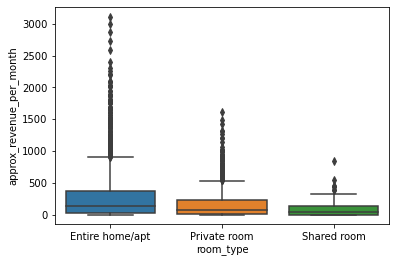

In [60]:
sns.boxplot(x='room_type', y='approx_revenue_per_month', data=listings)

From the chart above it is clear that the most profitable room type to rent out is the entire home/apartment. Therefore it is recommended to ensure that your rented accomodations be in the form of an entire home/apartment if possible.

## Which location gives the best bang for buck

In this section we will investigate which location gives the best rating for a given price. This will be done by creating a new column called `rating_per_dollar` which shows how much of an increase in rating a dollar investment will give you in a location.

In [61]:
listings['rating_per_dollar'] = listings.review_scores_value / listings.price

In [62]:
listings.rating_per_dollar.head()

0    0.036673
1    0.138462
2    0.153846
3    0.133333
4    0.126582
Name: rating_per_dollar, dtype: float64

It's probably best to create another dataframe specifically for analysing the `rating per dollar` for each of the neighbourhoods.

In [63]:
data = listings.groupby('neighbourhood_cleansed')['rating_per_dollar'].apply(np.mean)

In [64]:
neighbourhood_comp_cols = ['rating_per_dollar']
neighbourhood_comp = listings.groupby('neighbourhood_cleansed')[neighbourhood_comp_cols].apply(np.mean)

The geographic data needs to be obtained in order to produce a chloropleth. This was done using https://data.boston.gov/dataset/city-of-boston-boundary. Furthermore the `geopandas` library will be used to read this data.

In [65]:
import geopandas as gpd
sd = 'map/boston_neighborhood_shapefiles_iq5.shp'
boston_mapdf = gpd.read_file(sd)
boston_mapdf.head()

,OBJECTID,Name,Acres,SHAPE_area,SHAPE_len,geometry
0,1.0,Roslindale,1605.561815,6.993827e+07,53563.912597,"MULTIPOLYGON (((757409.123 2924367.749, 757457..."
1,2.0,Jamaica Plain,2519.235317,1.097379e+08,56349.937161,"POLYGON ((762983.826 2944104.016, 763014.250 2..."
2,3.0,Mission Hill,350.852160,1.528312e+07,17918.724114,"POLYGON ((766903.580 2947645.876, 766280.013 2..."
3,4.0,Longwood Medical Area,188.611192,8.215904e+06,11908.757148,"POLYGON ((764826.911 2947985.998, 764607.180 2..."
4,5.0,Bay Village,26.539733,1.156071e+06,4650.635493,"POLYGON ((773315.750 2952419.751, 773111.500 2..."


In [66]:
boston_mapdf.columns

Index(['OBJECTID', 'Name', 'Acres', 'SHAPE_area', 'SHAPE_len', 'geometry'], dtype='object')

Everyting looks good so far. In order to create a chloropleth though its better to merge the previously made `neighbourhood_comp` with the `boston_mapdf` dataframe. This will be done by performing an inner merge on the name of the neighbourhoods. However this requires changing the name of the1 `boston_mapdf` column `name` into `neighbourhood_cleansed`.

In [67]:
boston_mapdf.columns = ['OBJECTID', 'neighbourhood_cleansed', 'Acres', 'SHAPE_area', 'SHAPE_len', 'geometry']

In [68]:
boston_mapdf.head()

,OBJECTID,neighbourhood_cleansed,Acres,SHAPE_area,SHAPE_len,geometry
0,1.0,Roslindale,1605.561815,6.993827e+07,53563.912597,"MULTIPOLYGON (((757409.123 2924367.749, 757457..."
1,2.0,Jamaica Plain,2519.235317,1.097379e+08,56349.937161,"POLYGON ((762983.826 2944104.016, 763014.250 2..."
2,3.0,Mission Hill,350.852160,1.528312e+07,17918.724114,"POLYGON ((766903.580 2947645.876, 766280.013 2..."
3,4.0,Longwood Medical Area,188.611192,8.215904e+06,11908.757148,"POLYGON ((764826.911 2947985.998, 764607.180 2..."
4,5.0,Bay Village,26.539733,1.156071e+06,4650.635493,"POLYGON ((773315.750 2952419.751, 773111.500 2..."


So far so good

In [69]:
chloropleth_data = pd.merge(boston_mapdf,neighbourhood_comp, how='inner', on='neighbourhood_cleansed')
chloropleth_data.head()

,OBJECTID,neighbourhood_cleansed,Acres,SHAPE_area,SHAPE_len,geometry,rating_per_dollar
0,1.0,Roslindale,1605.561815,6.993827e+07,53563.912597,"MULTIPOLYGON (((757409.123 2924367.749, 757457...",0.122497
1,2.0,Jamaica Plain,2519.235317,1.097379e+08,56349.937161,"POLYGON ((762983.826 2944104.016, 763014.250 2...",0.096623
2,3.0,Mission Hill,350.852160,1.528312e+07,17918.724114,"POLYGON ((766903.580 2947645.876, 766280.013 2...",0.111743
3,4.0,Longwood Medical Area,188.611192,8.215904e+06,11908.757148,"POLYGON ((764826.911 2947985.998, 764607.180 2...",0.093973
4,5.0,Bay Village,26.539733,1.156071e+06,4650.635493,"POLYGON ((773315.750 2952419.751, 773111.500 2...",0.046762


In order to start plotting the centroid of each shape of the neighbourhood boundaries needs to be defined. Fortunately this is already predefined within the `geometry` column.

In [70]:
chloropleth_data['centre'] = chloropleth_data.geometry.centroid # Get centroid to plot data

1

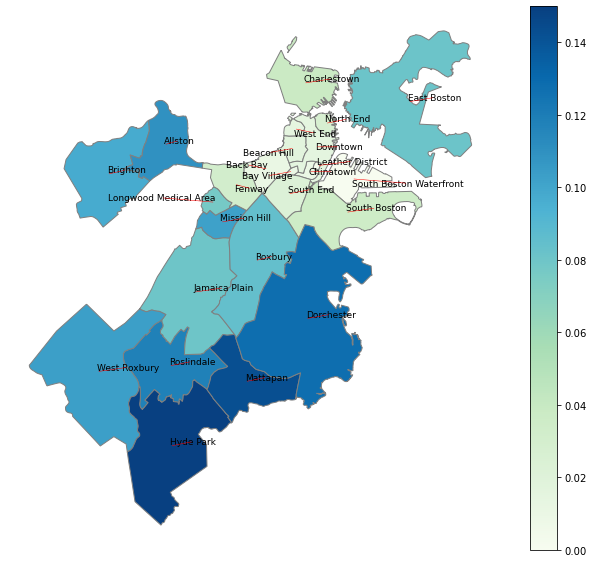

In [71]:
import adjustText as aT #This is to make the neighbourhood labels less clustered
vmin, vmax = 0, 0.15

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(13,10))

# add a title and annotation
ax.set_title('', fontdict={'fontsize': '25', 'fontweight' : '3'})

# create map
chloropleth_data.plot(column='rating_per_dollar', cmap='GnBu', linewidth=1, ax=ax, edgecolor='.5')


### Add a colar bar
ax.axis('off')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([])

#add colorbar
cbar = fig.colorbar(sm)

### Label areas

chloropleth_data['centre'] = chloropleth_data.geometry.centroid # Get centroid to plot data
za_points = chloropleth_data.copy()
za_points.set_geometry("centre",inplace = True)


texts = []

for x, y, label, area in zip(za_points.geometry.x, za_points.geometry.y, za_points["neighbourhood_cleansed"],
                            za_points.Acres):
    texts.append(plt.text(x, y, label, fontsize = 9))

aT.adjust_text(texts, force_points=0.2, force_text=0.7, expand_points=(1,1), expand_text=(1.01,1.01), 
               arrowprops=dict(arrowstyle="-", color='red', lw=0.5))

From the above figure it looks like the southern most areas get the highest rating per dollar and as you go further north the rating per dollar decreases. East Boston does defy this trend and there are a couple of other counterexamples to this statement. It also looks like if you want to stay somewhere Hyde Park will give you the best value.

## Which factors affect the pricing of a airbnb listing the most 

If you're a landlord then you probably wanna figure out which aspects of your property you want to improve on the most to raise the price. This will be done by using a machine learning model and using the parameters of the fitted model to determine the feature importance. Xgboost will be used since this is the state of the art for small to medium datasets at the time of writing.

In [73]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from xgboost import XGBRegressor

In [88]:
df = pd.read_csv('listings.csv')
df_price = df.price.apply(price_str2num)

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

So there are a few columns where the number of non-nulls are just too low like `has_availability`. These columns will be dropped along with redundant columns which don't offer much information like `state`.

In [95]:
df_filt_dropped = df_filtered.drop(columns=['license','jurisdiction_names','neighbourhood_group_cleansed',
                                            'square_feet','has_availability','latitude','longitude',
                                            'state','country_code','country','id', 'scrape_id', 'host_id'])

Now what is left is to create a pipeline for data and the machine learning model. First the missing data will be imputed using the mean (this makes sense since the data is numerical) and then scaled so that large values don't affect the training of the model. Finally the xg boosting algorithm will be used to perform regression the price.

In [96]:
ml_pipeline = Pipeline(steps=[
        ('imputer',SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model',XGBRegressor())
])

Now lets build the model. We'll just fit across the entire dataset since the model is just gonna be used to identify the most important features, not make predictions on price.

In [97]:
X = df_filt_dropped.select_dtypes(include=['int','float'])
y = df_price

In [98]:
def plot_sig_features(pipeline,X,y,n=5):
    """
    Creates a normalised plot of the most significant features.
    pipeline: Should be a pipeline of the relevant preprocessing steps and the model.
    The pipeline must have the ML step named 'model' and the model must have a feature_importances_
    attribute.
    X: A pandas dataframe of the features
    y:The regressor/classes
    n: The number of features to plot
    """
    pipeline.fit(X,y)
    signif = pipeline['model'].feature_importances_
    index = np.argsort(signif)[::-1][:n]
    
    col_names = X.columns[index]
    signif2plot = signif[index]
    
    plt.barh(col_names,signif2plot)
    plt.title('Feature Importances')
    plt.ylabel('Features')
    plt.xlabel('Normalised Feature Importances')
    plt.show()
    

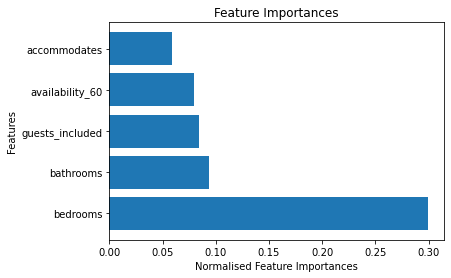

In [99]:
plot_sig_features(ml_pipeline,X,y)

The most important factor by far in determining the price of an accomodation are the number of bedrooms. The second most important factor is the number of bathrooms. This indicates that the most important factors in determining the price are associated with the number of rooms and likely the overall size of the accomodation. This is further evidenced by the `accomodates` feature which represents how many people a given accomodation can facilitate.

The `guests_included` column represents the number of guests which are included in the price per night. This implies that including more people can help raise the overall price of the accommodation. However it is noted that the price per person may drop so further research may be required in this regard.

What is interesting is that the `availability_60` feature has more importance than the `availability_365` feature. This implies that people hold more weight towards being able to stay within the timeframe of a couple months rather than the entirety of the year.  

## Deployment

From this notebook we have answered all the questions and have attained the following actionable information from each of the respective questions:

* __Which rooms are the most profitable to rent out?__

The most profitable rooms (in terms of revenue per month) to rent out are entire homes/apartments.

* __Which locations offer the best bang for buck in terms of renting?__

The best area to rent out in terms of rating per dollar is Hyde Park. With most of the best bang for buck locations being in the south of boston.

* __Which factors affect pricing the most?__ 

The most important features in determining the pricing of an accomodation by far are the number of bedrooms. Furthermore what is interesting is that most of the features such are largely associated with the overall size of the accomodation and it's ability to comfortably facilitate more guests.

## Resources Used

* https://www.kaggle.com/airbnb/boston: Data used to get information of listings
* https://data.boston.gov/dataset/city-of-boston-boundary: Data for the shapefile used to produce the chloropleth
* https://www.programmersought.com/article/27117592996/: A tutorial to show how to use the `geopandas` and `adjustText` library effectively.
* https://xgboost.readthedocs.io/en/latest/python/python_api.html: XGBoost documentation

For the complementary medium post check out https://medium.com/p/d986a958dab4/